## Characters influencing pollinator shift in the genus Fritillaria

![Fritillaria](Fritillaria_Flowers.jpg)

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from xgboost import plot_importance
from xgboost import plot_tree
import graphviz
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import itertools

In [2]:
#nectar, morphology and flower structure data
data = pd.read_csv("PELNE DANE.csv", delimiter=";", decimal=",")
#aminoacids, nectar proprerties
amino = pd.read_csv("aminokwasy.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 26 columns):
Gatunek    3029 non-null object
KOL        3029 non-null object
APZ        152 non-null float64
APW        147 non-null float64
D1         451 non-null float64
D2         452 non-null float64
PS         439 non-null float64
R          2519 non-null float64
SC         424 non-null float64
PL         2570 non-null float64
PYL        2564 non-null float64
K-J        2725 non-null float64
PYLZN      2212 non-null float64
PYLPL      2528 non-null float64
ZN         453 non-null float64
SZY        339 non-null float64
NB         249 non-null float64
KAT        278 non-null float64
V          505 non-null float64
KON        572 non-null float64
MASA       477 non-null float64
POW        948 non-null float64
NAS        793 non-null float64
WYS        793 non-null float64
SZER       793 non-null float64
SZEW       606 non-null float64
dtypes: float64(24), object(2)
memory usage: 615.3+ KB


In [4]:
amino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 38 columns):
Gatunek              53 non-null object
SEZON                53 non-null object
ORIGIN               53 non-null object
dominujący cukier    48 non-null object
ASP                  53 non-null float64
GLU                  53 non-null float64
ASN                  53 non-null float64
SER                  53 non-null float64
GLN                  53 non-null float64
GLY                  53 non-null float64
THR                  53 non-null float64
VAL                  53 non-null float64
MET                  53 non-null float64
LEU                  53 non-null float64
LYS                  53 non-null float64
ARG                  53 non-null float64
BALA                 53 non-null float64
ALA                  53 non-null float64
TYR                  53 non-null float64
PRO                  53 non-null float64
TRP                  53 non-null float64
PHE                  53 non-null float64

In [5]:
#removing unecessary colums
data.drop(["R", "K-J", "APZ", "APW"], axis=1, inplace=True)
amino.drop(["suma", 'SEZON'], axis=1, inplace=True)

In [6]:
#returns subspecies
def subgenus(name):
    if ((name == 'F. amabilis') | (name == 'F. ayakoana')):
        return "Japonica"
    elif ((name == 'F. affinis') | (name == 'F. gentneri') | (name == 'F. camtschatcensis') | 
          (name == 'F. eastwoodiae') | (name == 'F. liliacea') | (name == 'F. recurva')): 
        return "Liliorhiza"
    elif (name == 'F. sewerzowii'):
        return "Korolkowia"
    elif ((name == 'F. eduardii') | (name == 'F. imperialis') | (name == 'F. raddeana')):
        return "Petilium"
    elif ((name == 'F. bucharica') | (name == 'F. sthenanthera')):
        return "Rhinopetalum"
    elif (name == 'F. persica'):
        return "Theresia"
    elif ((name == 'F. grandiflora') | (name == 'F. olgae')):
        return "Other"
    else:
        return "Fritillaria"

In [7]:
#returns main pollinator
def pollinator(name):
    if((name == 'F. eduardii') | (name == 'F. imperialis')):
        return "PAS"
    elif ((name == 'F. camtchatcensis') | (name == 'F. drenovskii') | (name == 'F. graeca') | 
          (name == 'F. pyrenaica') | (name == 'F. thessala') | (name == 'F. ussuriensis')):
        return "FLY"
    elif ((name == "F. recurva") | (name == "F. gentnerii")):
        return "HUM"
    else:
        return "BEE"

In [8]:
#adding columns with subspecies and main pollinator name 
data['Subspecies'] = data['Gatunek'].apply(subgenus)
data['Pollinator'] = data['Gatunek'].apply(pollinator)

In [9]:
#mean for nectar features group by species
df = data.groupby(['Gatunek']).agg({'V': 'mean', 'KON': 'mean', 
                                    'MASA':'mean'}).reset_index()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
Gatunek    73 non-null object
V          44 non-null float64
KON        49 non-null float64
MASA       38 non-null float64
dtypes: float64(3), object(1)
memory usage: 2.4+ KB


In [11]:
df.dropna(inplace=True)

In [12]:
df['Pollinator'] = df['Gatunek'].apply(pollinator)
df['Subspecies'] = df["Gatunek"].apply(subgenus)

## Flower properites

In [13]:
# mean of angle and diagonal of flower
flow_prop = data.groupby(['Gatunek']).agg({'V': 'mean','KAT': 'mean',
                                   'PS': 'mean'}).reset_index()

In [14]:
flow_prop['Pollinator'] = flow_prop["Gatunek"].apply(pollinator)

In [15]:
col = {'BEE':'#228B22', 'PAS':'#ffe732', 'FLY':"#e5247e", 'HUM':'#46c4fd'}
flow_prop["colors"] = flow_prop.Pollinator.apply(lambda x: col[x])

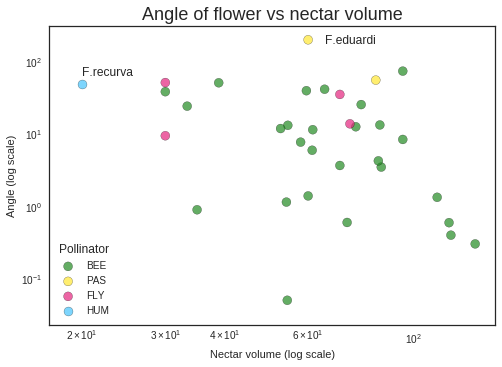

In [17]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = flow_prop.KAT[flow_prop.Pollinator == key], 
                y = flow_prop.V[flow_prop.Pollinator == key],
                s = 80,
                c = flow_prop.colors[flow_prop.Pollinator == key], alpha=0.7, edgecolors='black')

plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Angle (log scale)')
plt.title('Angle of flower vs nectar volume', fontsize=18)

plt.text(20, 64, 'F.recurva')
plt.text(65, 180, 'F.eduardi')
plt.legend(labels, title = "Pollinator", loc = 'lower left')

plt.show()

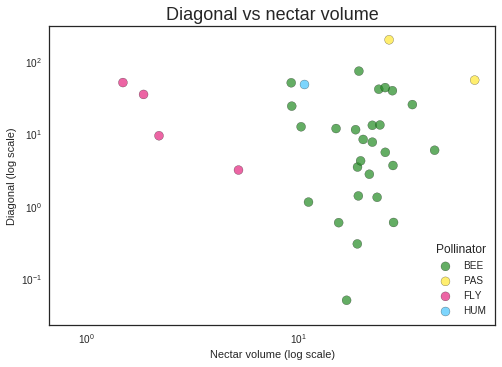

In [18]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = flow_prop.PS[flow_prop.Pollinator == key], 
                y = flow_prop.V[flow_prop.Pollinator == key],
                s = 80,
                c = flow_prop.colors[flow_prop.Pollinator == key], alpha=0.7, edgecolors='black')

plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Diagonal (log scale)')
plt.title('Diagonal vs nectar volume', fontsize=18)

#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
#plt.text(120, 24, 'F.imperialis')
#plt.text(70, 4, 'F.eduardi')

plt.legend(labels, title = "Pollinator", loc = 'lower right')
plt.show()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 24 columns):
Gatunek       3029 non-null object
KOL           3029 non-null object
D1            451 non-null float64
D2            452 non-null float64
PS            439 non-null float64
SC            424 non-null float64
PL            2570 non-null float64
PYL           2564 non-null float64
PYLZN         2212 non-null float64
PYLPL         2528 non-null float64
ZN            453 non-null float64
SZY           339 non-null float64
NB            249 non-null float64
KAT           278 non-null float64
V             505 non-null float64
KON           572 non-null float64
MASA          477 non-null float64
POW           948 non-null float64
NAS           793 non-null float64
WYS           793 non-null float64
SZER          793 non-null float64
SZEW          606 non-null float64
Subspecies    3029 non-null object
Pollinator    3029 non-null object
dtypes: float64(20), object(4)
memory usage: 568.

In [20]:
#removing cols with missing to many missing values - (NB, SZEW, SZY) and with nectar prop.
data.drop(["V", "MASA", "KON","Subspecies", "D1", "D2", "NB", "KAT", "SZY", "SZEW","PS", "SC","ZN", "NAS", "WYS", "SZER"], axis=1, inplace=True)

In [21]:
columns = data.columns
columns[2:12]

Index(['PL', 'PYL', 'PYLZN', 'PYLPL', 'POW', 'Pollinator'], dtype='object')

In [23]:
#filling na's with mean value for each species
for i in range(2,7):
    data.loc[data[columns[i]].isnull(), columns[i]] = data.groupby('Gatunek')[columns[i]].transform('mean')

In [24]:
data = data.dropna()

In [25]:
data.drop("Gatunek", axis=1, inplace=True)

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2821 entries, 0 to 3015
Data columns (total 7 columns):
KOL           2821 non-null object
PL            2821 non-null float64
PYL           2821 non-null float64
PYLZN         2821 non-null float64
PYLPL         2821 non-null float64
POW           2821 non-null float64
Pollinator    2821 non-null object
dtypes: float64(5), object(2)
memory usage: 176.3+ KB


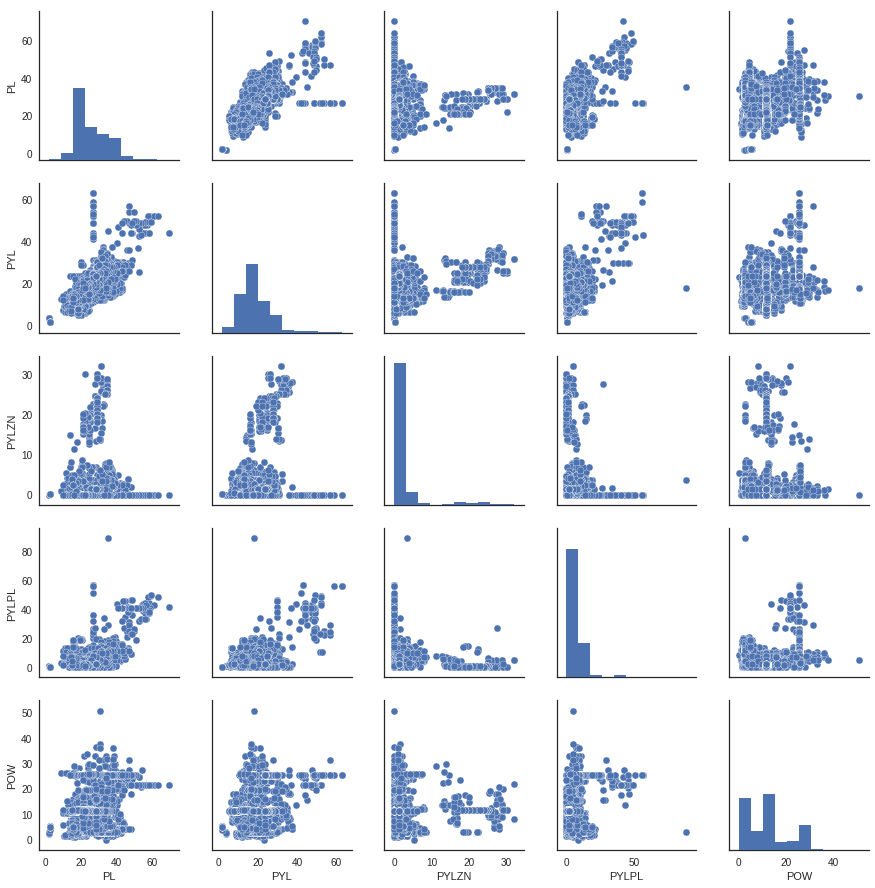

In [27]:
sns.pairplot(data)
plt.show()

In [28]:
#data['D1'].corr(data['D2'])

In [29]:
#data.drop("D2", axis=1, inplace=True)


In [ ]:
sns.pairplot(data.iloc[:,1:10])
plt.show()

In [30]:
X = data.drop("Pollinator", axis=1)
y = data.Pollinator

In [31]:
y.value_counts()

BEE    2339
PAS     399
FLY      47
HUM      36
Name: Pollinator, dtype: int64

In [32]:
X = pd.get_dummies(X,drop_first=True)
columnX = X.columns

In [33]:
le = LabelEncoder()
le.fit(y)
y_e = le.transform(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_e, test_size=0.25)

In [35]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(probability=True),  
          RandomForestClassifier(), 
          AdaBoostClassifier(),
         xgb.XGBClassifier()]

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = np.round(y_pred)

    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.02%
Accuracy: 99.43%
Accuracy: 97.31%
Accuracy: 99.29%
Accuracy: 97.31%
Accuracy: 99.43%


In [38]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [39]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [40]:
labels = ["BEE","HUM","FLY", "PAS"]

Confusion matrix, without normalization
[[587   2   0   0]
 [  3  11   0   0]
 [  0   0   5   0]
 [  0   0   0  98]]


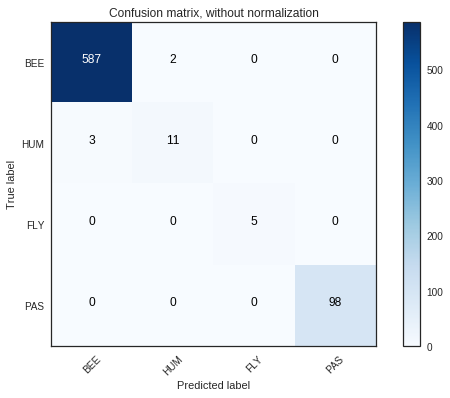

In [41]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

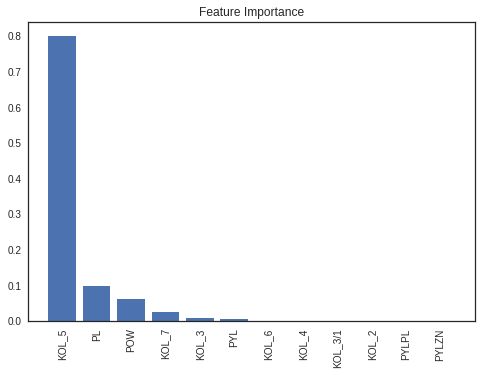

In [42]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [columnX[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [47]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       589
          1       0.85      0.79      0.81        14
          2       1.00      1.00      1.00         5
          3       1.00      1.00      1.00        98

avg / total       0.99      0.99      0.99       706



## Nectar properties

In [ ]:
col = {'BEE':'#228B22', 'PAS':'#ffe732', 'FLY':"#e5247e", 'HUM':'#46c4fd'}
df["colors"] = df.Pollinator.apply(lambda x: col[x])

In [ ]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = df.V[df.Pollinator == key], y = df.KON[df.Pollinator == key],
            s = np.array(df.MASA[df.Pollinator == key]) * 10000, 
            c = df.colors[df.Pollinator == key], alpha=0.7, edgecolors='black')

#plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Nectar concentration')
plt.title('Nectar volume vs nectar concentration', fontsize=18)
plt.xlim(0,350)

#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
plt.text(120, 24, 'F.imperialis')
plt.text(70, 4, 'F.eduardi')
lgnd = plt.legend(labels, title='Color by pollinator')
for i in range(len(col)):
    lgnd.legendHandles[i]._sizes = [60]

plt.text(67,55, "Size by mass")
plt.scatter(110, 51, s=100, c = 'white', edgecolors='k')
plt.text(140, 49.8,  "100ng")
# Show the plot
plt.show()

In [ ]:
col = {'Fritillaria':'#228B22', 'Rhinopetalum':'red', 'Liliorhiza':"#e5247e", 
       'Petilium':'#46c4fd', 'Other': "#00447C", 'Theresia': '#991188','Korolkowia': "#ffe732", "Japonica":'k'}

In [ ]:
df["colors"] = df.Subspecies.apply(lambda x: col[x])

In [ ]:
labels =[]
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = df.V[df.Subspecies == key], y = df.KON[df.Subspecies == key],
            s = np.array(df.MASA[df.Subspecies == key]) * 10000, 
            c = df.colors[df.Subspecies == key], alpha=0.7, edgecolors='black')

#plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Nectar volume (log scale)')
plt.ylabel('Nectar concentration')
plt.title('Nectar volume vs nectar concentration', fontsize=16)
plt.xlim(0,450)
#plt.xticks([1000,10000,100000], ['1k','10k','100k'])
plt.text(120, 24, 'F.imperialis')
plt.text(70, 4, 'F.eduardi')
lgnd = plt.legend(labels, title='Color by subspecies', loc="lower left")
for i in range(len(col)):
    lgnd.legendHandles[i]._sizes = [60]

plt.text(0.23,75, "Size by mass")
plt.scatter(0.32, 70, s=100, c = 'white', edgecolors='k')
plt.text(0.4, 69,  "100ng")
# Show the plot
plt.show()

In [ ]:
#total concentration of AA's in nectar
amino["Total"] = amino.iloc[:,3:33].sum(axis = 1)

In [ ]:
#mean concentration of AA's, nectar volume and nectar concentration
amino_mean = amino.groupby('Gatunek').mean().reset_index()

In [ ]:
amino_mean["Pollinator"] = amino_mean["Gatunek"].apply(pollinator)

In [ ]:
col = {'BEE':'#228B22', 'PAS':'#ffe732', 'FLY':"#e5247e", 'HUM':'#46c4fd'}
amino_mean["colors"] = amino_mean.Pollinator.apply(lambda x: col[x])

In [ ]:
labels =[]
sns.set_style("white")
for key, value in col.items():
    labels.append(key)
    plt.scatter(x = amino_mean.v[amino_mean.Pollinator == key], 
                y = amino_mean.Total[amino_mean.Pollinator == key],
                s = 80,
                c = amino_mean.colors[amino_mean.Pollinator == key], alpha=0.7, edgecolors='black')

plt.yscale('log')
plt.xscale('log') 
plt.xlabel('Mean nectar volume (log scale)')
plt.ylabel('Total concentration of aminoacids (log scale)')
plt.title('Nectar volume vs total concentration of aminoacids', fontsize=16)

plt.text(100, 15000, 'F.imperialis')
plt.text(55, 50000, 'F.eduardii')
#lgnd = plt.legend(labels, title='Color by pollinator')
#for i in range(len(col)):
#    lgnd.legendHandles[i]._sizes = [60]
plt.legend(labels, title = "Pollinator", loc = 'upper left')
# Show the plot
plt.show()

In [ ]:
amino.head()

In [ ]:
#Exploratory analysis of aminoacids in nectar by pollinator
df2 = amino.drop(["Gatunek", "ORIGIN", "dominujący cukier"], axis=1)
#reshaping df
df2 = pd.melt(df2, id_vars=['pollinator'])
df2.info()

In [ ]:
#selecting essential aa's except GLN
essential = df2[(df2.variable == "ASP")| (df2.variable == "GLU") | (df2.variable == "SER") |
         (df2.variable == "PRO") | (df2.variable == "GLY")| (df2.variable == "ALA") | 
         (df2.variable == "VAL")]

In [ ]:
#boxplots grouped by pollinator
plt.figure(figsize=(15,8))
sns.set_style("white")
ax = sns.boxplot(x="variable", y="value", hue="pollinator", data=essential, linewidth=1, width=1,
                 palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Aminoacid")
plt.ylabel("Value")
plt.legend(title="Pollinator")
plt.title("Essential AAs by pollinator", fontsize=20)
#ax.set_facecolor('white')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
ax.set_ylim(0,3000)
plt.show()

In [ ]:
df2.variable.unique()

In [ ]:
#boxplots grouped by pollinator
sns.set_style("white")
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="variable", y="value", hue="pollinator", 
                 data=df2[(df2.variable!="GLN") & (df2.variable !="Total") &
                         (df2.variable != 'v') & (df2.variable != '%')], 
                 linewidth=1, width=1,
                 palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Aminoacids")
plt.ylabel("Value")
plt.legend(title="Pollinator")
plt.title("Aminoacids by pollinator", fontsize = 20)
plt.xticks(rotation=45)
ax.set_facecolor('white')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
ax.set_ylim(0,3000)
plt.show()

In [ ]:
sns.boxplot(data=df2[df2.variable == "GLN"], x='pollinator', y='value', 
           palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Pollinator")
plt.ylabel("Value")
plt.title("GLN concentration by pollinator", fontsize = 18)
plt.show()

In [ ]:
sns.boxplot(data=df2[df2.variable == "Total"], x='pollinator', y='value', 
           palette=["#228B22", "#e5247e", "#ffe732", "#00447C","#991188"])
plt.xlabel("Pollinator")
plt.ylabel("Value")
plt.title("Total concentration of AAs by pollinator", fontsize=18)
plt.show()

In [ ]:
amino.head()

In [ ]:
#prepapring data
X = amino.drop(["pollinator", "Gatunek", "Total", "v", "%", "ORIGIN", "dominujący cukier" ], axis=1)
y = amino.pollinator
index = X.columns
X = StandardScaler().fit_transform(X)

In [ ]:
models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
         AdaBoostClassifier(), xgb.XGBClassifier(),
          BaggingClassifier(DecisionTreeClassifier(), bootstrap=False)]

for m in models:
    
    print("%s %.1f%%" % (m.__class__.__name__, cross_val_score(m,X,y,cv=3).mean()*100))

In [ ]:
model = xgb.XGBClassifier()
print(cross_val_score(model,X,y,cv=3).mean())
pd.Series(model.fit(X,y).feature_importances_, index = index).sort_values(ascending=False)
# Sort feature importances in descending order
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [index[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [ ]:
plot_tree(model)
#plt.savefig("tree.png", dpi=800)
plt.show()

In [ ]:
y.value_counts()

In [ ]:
y_pred = cross_val_predict(model, X, y, cv=3)
conf_mat = confusion_matrix(y, y_pred)
print(classification_report(y, y_pred))
labels=['BEE', 'FLY', 'HUM', 'LEP','PAS']

In [ ]:
plt.figure()
plot_confusion_matrix(conf_mat, classes=labels,
                      title='Confusion matrix')
plt.show()

In [ ]:
amino.dropna(inplace=True)
X_ext = amino.drop(["Gatunek", "ORIGIN", "pollinator"], axis=1)
X_ext = pd.get_dummies(X_ext,drop_first=True)
index_ext = X_ext.columns
y_ext = amino["pollinator"]
models = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
         AdaBoostClassifier(), xgb.XGBClassifier(),
          BaggingClassifier(DecisionTreeClassifier(), bootstrap=False)]

for m in models:
    
    print("%s %.1f%%" % (m.__class__.__name__, cross_val_score(m,X_ext,y_ext,cv=3).mean()*100))


In [ ]:
model_ext = xgb.XGBClassifier(n_estimators=100)
print(cross_val_score(model_ext,X_ext,y_ext,cv=3).mean())
model_ext.fit(X_ext,y_ext)
importances_ext = model_ext.feature_importances_
indices_ext = np.argsort(importances_ext)[::-1]

# Rearrange feature names so they match the sorted feature importances
names_ext = [index_ext[i] for i in indices_ext]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_ext.shape[1]), names_ext, rotation=90)

# Show plot
plt.show()

In [ ]:
y_pred_ext = cross_val_predict(model, X_ext, y_ext, cv=3)
conf_mat_ext = confusion_matrix(y_ext, y_pred_ext)
print(classification_report(y_ext, y_pred_ext))



In [ ]:
plt.figure()
plot_confusion_matrix(conf_mat_ext, classes=['BEE', 'FLY', 'HUM','LEP', 'PAS'],
                      title='Confusion matrix')
plt.show()

In [ ]:
# area = data.groupby(['Gatunek']).agg({'V': 'mean','POW': 'mean'}).reset_index()